In [36]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('abc').getOrCreate()
spark

df = spark.read.parquet("s3://502-project-1/data")

df.printSchema()
df = df.na.drop(subset=['profit'])
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()
df = df.na.fill(0)

df.createOrReplaceTempView("dfTable")
df = spark.sql("select *, CASE \
                   when profit >= 0 then 1 \
                   when profit < 0 then 0 \
                   end as label from dfTable")

cols = ['cik', 'company_name', 'assigned_sic', 'accession_number_int', 'filing_date', 
        'CostOfGoodsAndServicesSold', 'CostOfGoodsSold', 'CostOfServices', 'EarningsPerShareBasic', 
        'EarningsPerShareDiluted', 'GainLossOnDispositionOfAssets', 'GeneralAndAdministrativeExpense', 
        'IncomeTaxesPaid', 'IncreaseDecreaseInAccountsPayable', 'IncreaseDecreaseInAccountsReceivable', 
        'IncreaseDecreaseInAccruedLiabilities', 'IncreaseDecreaseInInventories', 'LaborAndRelatedExpense', 
        'NetCashProvidedByUsedInFinancingActivities', 
        'NetCashProvidedByUsedInFinancingActivitiesContinuingOperations', 
        'NetCashProvidedByUsedInInvestingActivities', 
        'NetCashProvidedByUsedInInvestingActivitiesContinuingOperations', 
        'NetCashProvidedByUsedInOperatingActivities', 
        'NetCashProvidedByUsedInOperatingActivitiesContinuingOperations', 'NetIncomeLoss', 'OperatingExpenses', 
        'OperatingIncomeLoss', 'PaymentsForRepurchaseOfCommonStock', 'PaymentsOfDividends', 
        'PaymentsOfDividendsCommonStock', 'PaymentsOfFinancingCosts', 
        'PaymentsToAcquireBusinessesNetOfCashAcquired', 'PaymentsToAcquirePropertyPlantAndEquipment', 
        'RepaymentsOfLongTermDebt', 'ResearchAndDevelopmentExpense', 'Revenues', 'SellingAndMarketingExpense', 
        'ShareBasedCompensation', 'year', 'profit_year', 'profit', 'label']

from pyspark.ml.feature import VectorAssembler

numericCols = ['CostOfGoodsAndServicesSold', 'CostOfGoodsSold', 'CostOfServices', 'EarningsPerShareBasic', 
               'EarningsPerShareDiluted', 'GainLossOnDispositionOfAssets', 'GeneralAndAdministrativeExpense', 
               'IncomeTaxesPaid', 'IncreaseDecreaseInAccountsPayable', 'IncreaseDecreaseInAccountsReceivable', 
               'IncreaseDecreaseInAccruedLiabilities', 'IncreaseDecreaseInInventories', 
               'LaborAndRelatedExpense', 'NetCashProvidedByUsedInFinancingActivities', 
               'NetCashProvidedByUsedInFinancingActivitiesContinuingOperations', 
               'NetCashProvidedByUsedInInvestingActivities', 'NetCashProvidedByUsedInInvestingActivitiesContinuingOperations', 
               'NetCashProvidedByUsedInOperatingActivities', 'NetCashProvidedByUsedInOperatingActivitiesContinuingOperations', 
               'NetIncomeLoss', 'OperatingExpenses', 'OperatingIncomeLoss', 'PaymentsForRepurchaseOfCommonStock', 
               'PaymentsOfDividends', 'PaymentsOfDividendsCommonStock', 'PaymentsOfFinancingCosts', 'PaymentsToAcquireBusinessesNetOfCashAcquired', 
               'PaymentsToAcquirePropertyPlantAndEquipment', 'RepaymentsOfLongTermDebt', 'ResearchAndDevelopmentExpense', 
               'Revenues', 'SellingAndMarketingExpense', 'ShareBasedCompensation']

assembler = VectorAssembler(inputCols=numericCols, outputCol="features", handleInvalid="keep")

from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[assembler])

from pyspark.sql.functions import isnan, count, when, col, isnull

pipelineModel = pipeline.fit(df)

df = pipelineModel.transform(df)
selectedCols = ['features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- cik: integer (nullable = true)
 |-- company_name: string (nullable = true)
 |-- assigned_sic: integer (nullable = true)
 |-- accession_number_int: long (nullable = true)
 |-- filing_date: date (nullable = true)
 |-- CostOfGoodsAndServicesSold: double (nullable = true)
 |-- CostOfGoodsSold: double (nullable = true)
 |-- CostOfServices: double (nullable = true)
 |-- EarningsPerShareBasic: double (nullable = true)
 |-- EarningsPerShareDiluted: double (nullable = true)
 |-- GainLossOnDispositionOfAssets: double (nullable = true)
 |-- GeneralAndAdministrativeExpense: double (nullable = true)
 |-- IncomeTaxesPaid: double (nullable = true)
 |-- IncreaseDecreaseInAccountsPayable: double (nullable = true)
 |-- IncreaseDecreaseInAccountsReceivable: double (nullable = true)
 |-- IncreaseDecreaseInAccruedLiabilities: double (nullable = true)
 |-- IncreaseDecreaseInInventories: double (nullable = true)
 |-- LaborAndRelatedExpense: double (nullable = true)
 |-- NetCashProvidedByUsedInFinan

In [37]:
df.count()

17662

In [39]:
df.show(5,False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+-----------------------------------+------------+--------------------+-----------+--------------------------+---------------+--------------+---------------------+-----------------------+-----------------------------+-------------------------------+---------------+---------------------------------+------------------------------------+------------------------------------+-----------------------------+----------------------+------------------------------------------+--------------------------------------------------------------+------------------------------------------+--------------------------------------------------------------+------------------------------------------+--------------------------------------------------------------+------------

In [40]:
train, test = df.randomSplit([0.85, 0.15], seed=1)

In [41]:
from pyspark.ml.classification import LogisticRegression

In [42]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)

In [43]:
lrModel = lr.fit(train)

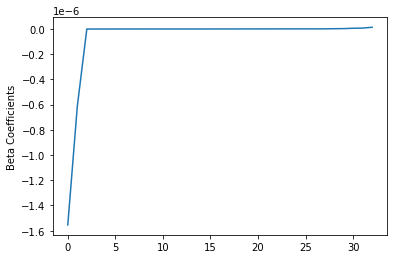

In [44]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

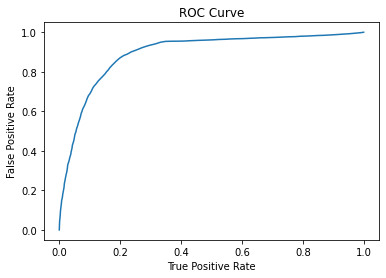

Training set areaUnderROC: 0.8931591090689553


In [45]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

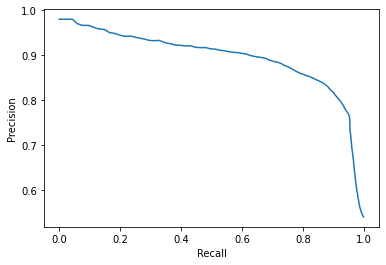

In [46]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [47]:
predictions = lrModel.transform(test)
predictions.show(10)

+--------------------+-------+--------------------+------------+--------------------+-----------+--------------------------+---------------+--------------+---------------------+-----------------------+-----------------------------+-------------------------------+---------------+---------------------------------+------------------------------------+------------------------------------+-----------------------------+----------------------+------------------------------------------+--------------------------------------------------------------+------------------------------------------+--------------------------------------------------------------+------------------------------------------+--------------------------------------------------------------+-------------+-----------------+-------------------+----------------------------------+-------------------+------------------------------+------------------------+--------------------------------------------+----------------------------------

In [48]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.901940172428398
